<a href="https://colab.research.google.com/github/al3jandroR/nba_predictions/blob/colab/nba_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nba_api

In [4]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import scoreboardv2
from nba_api.stats.endpoints import PlayerProfileV2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import commonteamroster

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

from datetime import datetime, timedelta
import numpy as np
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
nba_teams = teams.get_teams()
teams_df = pd.DataFrame(nba_teams)

In [ ]:
# Helper function to avoid api rate limits
def safe_request(func, *args, **kwargs):
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)

def get_team_id(abbr):
    team = teams_df[teams_df['abbreviation'] == abbr.upper()]
    if not team.empty:
        return team.iloc[0]['id']
    else:
        raise ValueError(f"Team abbreviation '{abbr}' not found.")

def get_team_abbr(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['abbreviation']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_name(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['full_name']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_stats(team_id, season, n=5):
    log = safe_request(teamgamelog.TeamGameLog, team_id=team_id, season=season)
    df = log.get_data_frames()[0]

    df = df[['GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']].copy()

    df['SEASON'] = season
    df['TEAM'] = get_team_name(team_id)
    df['HOME'] = df['MATCHUP'].str.contains('vs.').astype(int)
    df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0)
    df['STREAK'] = df['WIN'].rolling(window=n).sum().shift(-1).fillna(0)
    df['OPP_ABBR'] = df['MATCHUP'].str.extract(r'@ (\w+)|vs\. (\w+)').bfill(axis=1).iloc[:, 0]

    # avg stats from last 5 games
    rolling_features = ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']
    for col in rolling_features:
        df[f'{col}_AVG'] = df[col].rolling(window=n).mean().shift(-1)

    df['DEFENSE_SCORE'] = df['STL_AVG'] + df['BLK_AVG'] + df['DREB_AVG']
    df['AST_TOV_RATIO'] = df['AST_AVG'] / (df['TOV_AVG'] + 1)
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y')
    df['EFFICIENCY'] = df['FG_PCT_AVG'] * df['PTS_AVG']
    df['PREV_GAME_DATE'] = df['GAME_DATE'].shift(-1)
    df['DAYS_REST'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.clip(lower=0)
    df['BACK_TO_BACK'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.eq(1).astype(int)
    df['B2B_ROAD'] = (df['BACK_TO_BACK'] == 1) & (df['HOME'] == 0).astype(int)

    df['FORM_SCORE'] = df['AST_TOV_RATIO'] + df['DEFENSE_SCORE'] + df['EFFICIENCY']

    df = df.dropna().reset_index(drop=True)
    return df

def add_opponent_features(df):
    abbr_to_name = teams_df.set_index('abbreviation')['full_name'].to_dict()
    df['OPPONENT_TEAM'] = df['OPP_ABBR'].map(abbr_to_name)

    df['GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['TEAM']
    df['OPP_GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['OPPONENT_TEAM']

    eff_map = df.set_index('GAME_KEY')['EFFICIENCY'].to_dict()
    form_map = df.set_index('GAME_KEY')['FORM_SCORE'].to_dict()
    streak_map = df.set_index('GAME_KEY')['STREAK'].to_dict()

    df['OPP_EFFICIENCY'] = df['OPP_GAME_KEY'].map(eff_map).fillna(0)
    df['OPP_FORM_SCORE'] = df['OPP_GAME_KEY'].map(form_map).fillna(0)
    df['OPP_STREAK'] = df['OPP_GAME_KEY'].map(streak_map).fillna(0)

    df['NET_EFFICIENCY'] = df['EFFICIENCY'] - df['OPP_EFFICIENCY']
    df['NET_FORM_SCORE'] = df['FORM_SCORE'] - df['OPP_FORM_SCORE']
    df['NET_STREAK'] = df['STREAK'] - df['OPP_STREAK']

    df = df.dropna().reset_index(drop=True)
    return df

def getPlayerImpact(playerId):
  player = playerId
  df = safe_request(PlayerProfileV2.PlayerProfileV2(player_id=player, per_mode36='Totals').get_data_frames()[0])
  df = df.tail(1)
  if df['MIN'].iloc[0] < 200:
      return 0
  df['WEIGHTED_RANK_SCORE'] = (
  df['PTS']     * 2.0 +   # Scoring is key
  df['AST']     * 1.8 +   # Playmaking
  df['REB']     * 1.5 +   # Rebounding (OREB + DREB combined)
  df['STL']     * 1.5 +   # Defense
  df['BLK']     * 1.2 +   # Rim protection
  df['TOV']     * -2.0 +  # Turnovers are bad → negative weight
  df['FG_PCT'] * 1.2 +   # Shooting efficiency
  df['FG3_PCT'] * 0.8 +   # 3PT efficiency
  df['FT_PCT']  * 0.6   # Overall efficiency stat
  )
  return np.round(df['WEIGHTED_RANK_SCORE'].values[0] * (36/(df['MIN'].values[0])), 3)

def getPlayers(team_id, seasonPlayed):
    players = safe_request(commonteamroster(team_id=team_id, season=seasonPlayed).get_data_frames()[0])
    players = players[['PLAYER_ID', 'PLAYER']]
    return players

def rankPlayers(team_id, seasonPlayed):
  playerImpacts = []
  players = getPlayers(team_id, seasonPlayed)
  for index, row in players.iterrows():
    id = row['PLAYER_ID']
    name = row['PLAYER']
    playerImpacts.append((name, id, getPlayerImpact(id)))
  playerImpacts.sort(key=lambda x: x[2], reverse=True)
  return pd.DataFrame(playerImpacts, columns=['Player Name', 'Id', 'Rank'])

In [ ]:
all_team_dfs = []
seasons = ['2023-24', '2024-25']
for season in seasons:
  for team in nba_teams:
      try:
          print(f"Loading {team['full_name']} - {season}...")
          team_data = get_team_stats(team['id'], season)
          team_data['Team'] = team['full_name']

          all_team_dfs.append(team_data)
          time.sleep(1.5)
      except Exception as e:
          print(f"Skipping {team['full_name']} due to error")

Loading Atlanta Hawks - 2023-24...
Loading Boston Celtics - 2023-24...
Loading Cleveland Cavaliers - 2023-24...
Loading New Orleans Pelicans - 2023-24...
Loading Chicago Bulls - 2023-24...
Loading Dallas Mavericks - 2023-24...
Loading Denver Nuggets - 2023-24...
Loading Golden State Warriors - 2023-24...
Loading Houston Rockets - 2023-24...
Loading Los Angeles Clippers - 2023-24...
Loading Los Angeles Lakers - 2023-24...
Loading Miami Heat - 2023-24...
Loading Milwaukee Bucks - 2023-24...
Loading Minnesota Timberwolves - 2023-24...
Loading Brooklyn Nets - 2023-24...
Loading New York Knicks - 2023-24...
Loading Orlando Magic - 2023-24...
Loading Indiana Pacers - 2023-24...
Loading Philadelphia 76ers - 2023-24...
Loading Phoenix Suns - 2023-24...
Loading Portland Trail Blazers - 2023-24...
Loading Sacramento Kings - 2023-24...
Loading San Antonio Spurs - 2023-24...
Loading Oklahoma City Thunder - 2023-24...
Loading Toronto Raptors - 2023-24...
Loading Utah Jazz - 2023-24...
Loading Memph

In [ ]:
df = pd.concat(all_team_dfs).reset_index(drop=True)
team_data = add_opponent_features(df)
features = ['AST_TOV_RATIO', 'DEFENSE_SCORE', 'EFFICIENCY', 'FG_PCT_AVG', 'PTS_AVG', 'HOME', 'B2B_ROAD', 'DAYS_REST', 'BACK_TO_BACK', 'FORM_SCORE', 'NET_FORM_SCORE', 'NET_EFFICIENCY', 'NET_STREAK', 'STREAK']
X = df[features]
y = df['WIN']

trainSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in trainSplit.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:

best_model = None
best_score = 0

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)
if rf_grid.best_score_ > best_score:
    best_score = rf_grid.best_score_
    best_model = rf_grid.best_estimator_

gb_param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=cv, scoring='accuracy')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting score:", gb_grid.best_score_)
if gb_grid.best_score_ > best_score:
    best_score = gb_grid.best_score_
    best_model = gb_grid.best_estimator_

Best Random Forest params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest score: 0.7908602150537634
Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best Gradient Boosting score: 0.7919354838709678


[[365 100]
 [102 363]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       465
           1       0.78      0.78      0.78       465

    accuracy                           0.78       930
   macro avg       0.78      0.78      0.78       930
weighted avg       0.78      0.78      0.78       930

Model Accuracy: 0.78
Train Accuracy: 0.85
Test Accuracy:  0.78


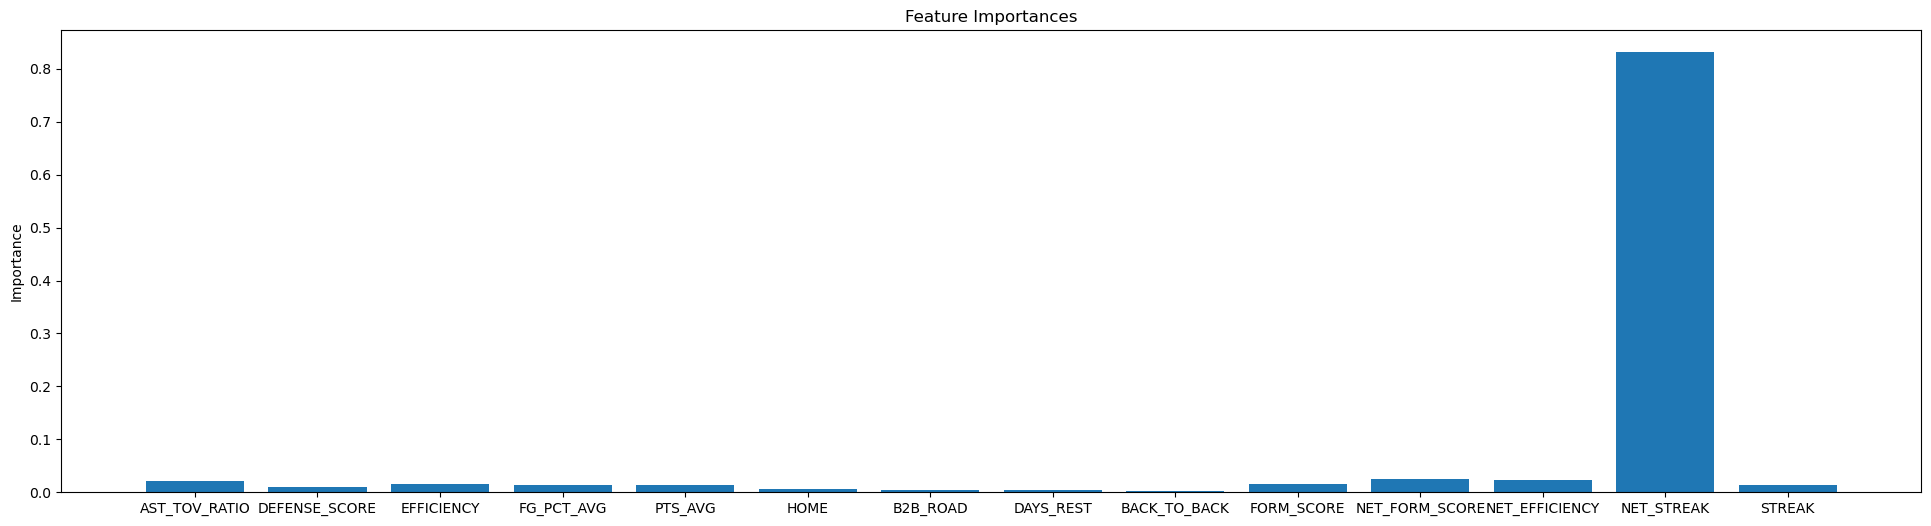

Feature Comparison (F-test vs Model Importance):
Feature                 F-Score     Model Importance
AST_TOV_RATIO            177.95               0.0207
DEFENSE_SCORE            236.20               0.0097
EFFICIENCY               376.36               0.0156
FG_PCT_AVG               297.20               0.0135
PTS_AVG                  352.19               0.0144
HOME                      27.02               0.0053
B2B_ROAD                  15.10               0.0038
DAYS_REST                  2.25               0.0035
BACK_TO_BACK              13.88               0.0028
FORM_SCORE               525.29               0.0157
NET_FORM_SCORE           953.17               0.0258
NET_EFFICIENCY           769.44               0.0234
NET_STREAK              2821.56               0.8311
STREAK                  1424.44               0.0147


In [ ]:
clf = best_model
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")

importances = clf.feature_importances_
plt.figure(figsize=(24, 6))
plt.bar(features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
f_scores = selector.scores_

print("Feature Comparison (F-test vs Model Importance):")
print("{:<20s} {:>10s} {:>20s}".format("Feature", "F-Score", "Model Importance"))
for name, f, imp in zip(X_train.columns, f_scores, importances):
    print(f"{name:<20s} {f:10.2f} {imp:20.4f}")

Win rates by BACK_TO_BACK status:
BACK_TO_BACK
0    0.513203
1    0.440000
Name: WIN, dtype: float64


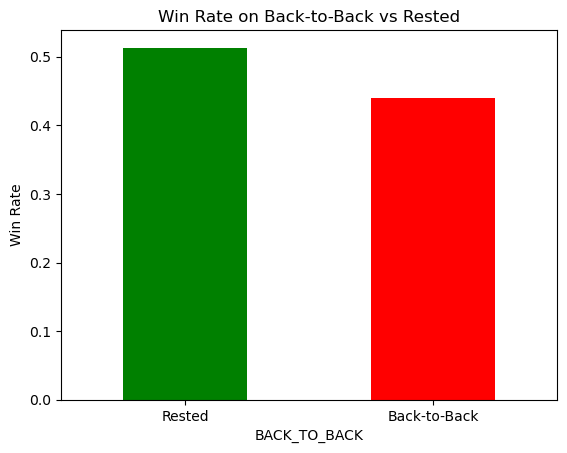

In [10]:
b2b_grouped = df.groupby('BACK_TO_BACK')['WIN'].mean()
print("Win rates by BACK_TO_BACK status:")
print(b2b_grouped)

b2b_grouped.plot(kind='bar', color=['green', 'red'], title='Win Rate on Back-to-Back vs Rested')
plt.xticks([0, 1], ['Rested', 'Back-to-Back'], rotation=0)
plt.ylabel('Win Rate')
plt.show()

b2b_penalty_ratio = b2b_grouped[1] / b2b_grouped[0]

In [ ]:
#####--------RUN MODEL FOR TODAYS GAMES--------#####

#today = datetime.now(timezone('US/Eastern')).strftime('%Y-%m-%d')
today = (datetime.now(timezone('US/Eastern')) - timedelta(days=1)).strftime('%Y-%m-%d')
tomorrow = (datetime.now(timezone('US/Eastern')) + timedelta(days=1)).strftime('%Y-%m-%d')
date = tomorrow

print("Fetching games for:", date, "\n")
while True:
    try: 
        scoreboard = scoreboardv2.ScoreboardV2(game_date=date)
        games = scoreboard.get_data_frames()[0]
        break
    except:
        print('Trying Again...')

matchups = games[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

for _, row in matchups.iterrows():
    home_id = row['HOME_TEAM_ID']
    away_id = row['VISITOR_TEAM_ID']
    home = get_team_abbr(home_id)
    away = get_team_abbr(away_id)
    if home == 'DEN':
        try:
            home_df = get_team_stats(home_id, season='2024-25').head(1).copy()
            away_df = get_team_stats(away_id, season='2024-25').head(1).copy()

            home_df['OPP_ABBR'] = away
            away_df['OPP_ABBR'] = home

            matchup_df = pd.concat([home_df, away_df], ignore_index=True)
            matchup_df = add_opponent_features(matchup_df)

            home_stats = matchup_df[matchup_df['TEAM'] == get_team_name(home_id)].copy()
            away_stats = matchup_df[matchup_df['TEAM'] == get_team_name(away_id)].copy()

            X_home = home_stats[features]
            X_away = away_stats[features]

            home_proba = clf.predict_proba(X_home)[0][1]
            away_proba = clf.predict_proba(X_away)[0][1]
            total = home_proba + away_proba
            nhome_proba = home_proba / total
            naway_proba = away_proba / total

            winner = home if home_proba > away_proba else away

            print(f"{away} @ {home} → {winner}")
            print(f"{home} win probability: {nhome_proba:.2f} (raw: {home_proba:.2f})")
            print(f"{away} win probability: {naway_proba:.2f} (raw: {away_proba:.2f})\n")

            #total_points_estimate = home_stats[f'PTS_AVG'].values[0] + away_stats[f'PTS_AVG'].values[0]
            #print(f"Estimated total points (Over/Under baseline): {total_points_estimate:.1f}")

            #spread_estimate = abs(home_proba - away_proba) * 10
            #print(f"Estimated spread: {spread_estimate:.1f}\n")

        except Exception as e:
            print(f"Error predicting {away} @ {home}: {e}")

NameError: name 'datetime' is not defined